### Importing the Dataset

In [37]:
import numpy as np
import pandas as pd

posts = pd.read_csv("../data/total_posts.csv", names=["text", "user", "label", "date"])

posts['label'] = pd.to_numeric(posts['label'], errors='coerce')
posts = posts.dropna(subset=['label'])

/tmp/ipykernel_4614/927668617.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  posts = pd.read_csv("../data/total_posts.csv", names=["text", "user", "label", "date"])


In [47]:
posts = posts.drop(['user', 'date'], axis=1)

In [52]:
posts = posts[posts['label'] < 2]

### Exploring the Dataset

In [53]:
posts.head()

,text,label
578731,Spiritual selflessness vs. the self denial con...,0.0
601918,Can I and should I train my left hand to becom...,0.0
9419,i dont wanna go to fuggin college i want to ru...,1.0
603149,I've told the story of my abuse (anonymously o...,0.0
595446,Yeah well if we're free to ask questions wh...,0.0


In [54]:
posts.value_counts(subset='label')

label
0.0    478136
1.0    225002
Name: count, dtype: int64

### Splitting the Dataset

In [56]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(posts, test_size=0.1, random_state=42, stratify=posts['label'])

#### Analyzing the Dataset

In [41]:
posts = strat_train_set.copy()
posts.head()

,text,user,label,date
578731,Spiritual selflessness vs. the self denial con...,"""is_reddit_useful""",0.0,2020-06-11
601918,Can I and should I train my left hand to becom...,"""firealpaca11""",0.0,2020-06-23
9419,i dont wanna go to fuggin college i want to ru...,"""InnerCatch""",1.0,2020-01-12
603149,I've told the story of my abuse (anonymously o...,"""BN975""",0.0,2020-06-23
595446,Yeah well if we're free to ask questions wh...,"""huna-lildahk""",0.0,2020-06-19


In [57]:
post_lengths = [len(post.split()) for post in posts["text"] if len(post.split()) < 1500]

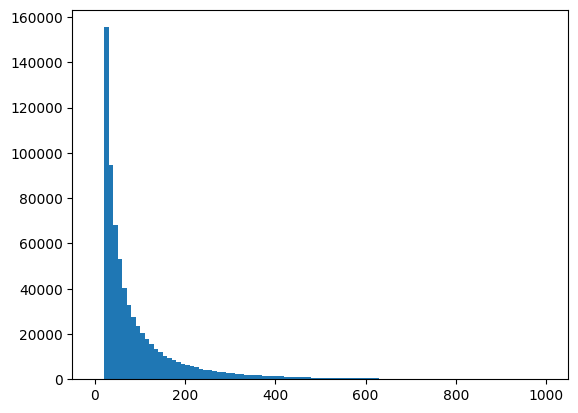

In [58]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=100)
plt.show()

### Preprocessing

#### Creating validation data

In [61]:
strat_train_set, strat_val_set = train_test_split(posts, test_size=1/9, random_state=42, stratify=posts['label'])

strat_train_set[:5]

,text,label
141127,Can I please have someone to vent to my life ...,1.0
26938,Im going to need to delete lots of memes soon....,1.0
730920,So i looked at recent portal results on my hpv...,0.0
696038,Crisis support is a load so an hour talking to...,0.0
939500,New to gunpla always had an interest in the ba...,0.0


#### Tokenizing the posts

In [62]:
import spacy

print(spacy.prefer_gpu())

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

nlp.pipe_names

True


['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [63]:
doc = nlp('I was reading the paper.')
print([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

['read', 'paper']


In [68]:
import pickle
from tqdm import tqdm

def preprocess_set(set, directory):
    print(f'Preprocessing {directory} data')

    texts = set.copy()['text']
    labels = set.copy()['label']
    texts = [' '.join(text.split()[:500]) for text in texts]

    docs = (doc for doc in (nlp.pipe(texts)))
    processed_texts = []
    for doc in tqdm(docs, total=len(texts), ncols=80):
        lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(' '.join(lemmas))
    
    labels = np.array(labels)

    from pathlib import Path
    Path(f"{directory}").mkdir(parents=True, exist_ok=True)

    with open(f"{directory}/texts.pkl", "wb") as fp:
        pickle.dump(processed_texts, fp)
    
    with open(f"{directory}/labels.pkl", "wb") as fp:
        pickle.dump(labels, fp)

    return processed_texts, labels

In [69]:
len(strat_train_set)

625011

In [70]:
preprocess_set(strat_train_set, 'train')
preprocess_set(strat_val_set, 'val')
preprocess_set(strat_test_set, 'test')

print()

Preprocessing train data


100%|██████████████████████████████████| 625011/625011 [13:48<00:00, 754.50it/s]


Preprocessing val data


100%|████████████████████████████████████| 78127/78127 [01:42<00:00, 765.52it/s]


Preprocessing test data


100%|████████████████████████████████████| 70314/70314 [01:30<00:00, 773.55it/s]